In [40]:
%load_ext autoreload
%autoreload 2
from method import IV
import nest
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from exana.statistics import plot_xcorr
import neo
%matplotlib inline

rc = {
    'figure.figsize' : (9, 9),
    'axes.labelsize' : 25,
    'lines.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'axes.titlesize' : 20,
    'font.size'      : 20,
    'legend.frameon' : False,
    'legend.fontsize': 20,
    'font.family'    : 'serif',
#     'font.serif'     : Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman
#     'font.sans-serif': Helvetica, Avant Garde, Computer Modern Sans serif
#     'font.cursive'   : Zapf Chancery
#     'font.monospace' : Courier, Computer Modern Typewriter
    'text.usetex'    : True}
sns.set(rc=rc)
sns.set_color_codes()
plt.rcParams.update(rc)

sns.set_style('white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Slow synapse parameters

In [109]:
# more noise
# longer EPSP rise time 4 ms, duration 20 ms
par = {
    'msd'            : 1234, # Master seed
    'num_threads'    : 4,
    'N_neurons'      : 3,
    'res'            : 0.1, # Temporal resolution for simulation Delta t in ms
    'delay'          : 1.5, # Synaptic delay in ms
    'rate_p'         : 1000., # external poisson rate in Hz
    'J_p'            : .3,
    'gauss_mean'     : .1,
    'gauss_std'      : 1.1,
    # Neuron parameters
    't_ref'          : 2.0, # Duration of refractory period in ms
    'V_m'            : 0.0, # Membrane potential, initial condition in mV
    'E_L'            : 0.0, # Leak reversal potential in mV
    'V_reset'        : 0.0, # Reset potential of the membrane in mV
    'tau_m'          : 20.0, # Membrane timeconstant in ms
    'C_m'            : 1.0, # Capacity of the membrane in pF
    'V_th'           : 20.0, # Spike threshold in mV
    'tau_syn_ex'     : 1., # Time constants of the excitatory synaptic exponential function in ms
    'tau_syn_in'     : .1, # Time constants of the inhibitory synaptic exponential function in ms
    # Connection parameters
    'J_AB'           : 0., # mV
    'J_AC'           : 0,
    'J_BC'           : .0002,
#     'J_BC'           : 1.5,
    'J_BA'           : 0,
    'J_CA'           : 0,
    'J_CB'           : 0,
    # Stimulation parameters
    'trial_amp_A'    : 10.0, # pA
    'trial_amp_B'    : 10.0, # pA
    'trial_period'   : 30.0, # ms
    'trial_duration' : 2.0, # ms
    'N_trials'       : 10000,
}

In [110]:
import os.path as op
def savefig(fig, fname, **kwargs):
    fig.savefig(op.join('manuscript',fname + '.pdf'), **kwargs)
    pass

# Set kernel

In [111]:
nest.ResetKernel()
nest.SetKernelStatus({"local_num_threads": par['num_threads']})
N_vp = nest.GetKernelStatus(['total_num_virtual_procs'])[0]
pyrngs = [np.random.RandomState(s) for s in range(par['msd'], par['msd'] + N_vp)]
nest.SetKernelStatus({'grng_seed' : par['msd'] + N_vp})
nest.SetKernelStatus({'rng_seeds' : range(par['msd'] + N_vp + 1, par['msd'] + 2 * N_vp + 1)})
nest.SetStatus([0], [{"resolution": par['res']}])

# Make the nodes

In [112]:
nodes = nest.Create('iaf_psc_alpha', par['N_neurons'])
keys = ['t_ref', 'V_m', 'E_L', 'V_reset', 'tau_m', 'C_m', 'V_th', 'tau_syn_ex', 'tau_syn_in']
nest.SetStatus(nodes, [{k: par[k] for k in keys}])

# Connect nodes

In [113]:
## multisynapse
conn_dict = {'rule': 'fixed_indegree', 'indegree': 10000}
nest.Connect(tuple([nodes[1]]), tuple([nodes[2]]),
             conn_dict,
             {"weight": par['J_BC'], "delay": par['delay']})

# Set background drive

In [114]:
background = nest.Create("poisson_generator", 1,
                          params={"rate": par['rate_p']})
nest.Connect(background, nodes, 
             {'rule': 'fixed_indegree', 'indegree': 1},
             {"weight": par['J_p'], "delay": par['res']})

# Set channel noise

In [115]:
channelnoise = nest.Create("noise_generator", 1,
                          params={"mean": par['gauss_mean'],
                                  'std': par['gauss_std']})
nest.Connect(channelnoise, nodes)

# Connect spike detector

In [116]:
spks = nest.Create("spike_detector", 1,
                     params=[{"label": "Exc", "to_file": False}])
# connect using all_to_all: all recorded excitatory neurons to one detector
nest.Connect(nodes, spks)

# Connect voltage meter

In [117]:
vm = nest.Create("multimeter",
    params = {"interval": par['res'],
              "record_from": ['V_m'],
              "withgid": True, "to_file": False,
              "label": 'vm', "withtime": True})
nest.Connect(vm, nodes)

# Simulate one period without stimulation

In [118]:
nest.Simulate(par['trial_period'])

# Set dc stimulation

In [119]:
stims = []
for n, a in enumerate([par['trial_amp_A'], par['trial_amp_B']]):
    stim = nest.Create(
        "dc_generator",
        params={'amplitude': a,
                'start': 0.,
                'stop': par['trial_duration']})
    nest.Connect(stim, tuple([nodes[n]]))
    stims.append(stim)

# Run multiple trials

In [120]:
events = []
for n in range(par['N_trials']):
    for stim in stims:
        nest.SetStatus(stim, {'origin': nest.GetKernelStatus()['time']})
    nest.Simulate(par['trial_period'])
    events.append(par['trial_period'] * (n + 1))
nest.Simulate(par['trial_period'])

# Organize data

In [121]:
conns = nest.GetConnections(source=nodes, target=nodes)
data = {
    'spiketrains': nest.GetStatus(spks, 'events')[0],
    'state': nest.GetStatus(vm, 'events')[0],
    'epochs': {'times': events, 'durations': [par['trial_duration']] * par['N_trials']},
    'connections': list(nest.GetStatus(conns)),
    'status': nest.GetKernelStatus()
}

In [122]:
# colors = sns.xkcd_palette(["windows blue", "amber", "faded green"])
# colors = ['b', 'orange', 'g']
colors = sns.color_palette()
names = ['A', 'B', 'C']

In [123]:
np.savez('t_{}'.format(par['N_trials']), data=data)
# data_l = np.load('t_5000.npz')['data'][()]
data_l = data

In [136]:
df = pd.DataFrame(data_l['spiketrains'])
t_stop = data_l['status']['time']
spiketrains = [attr['times'].values for sndr, attr in df.groupby('senders')]

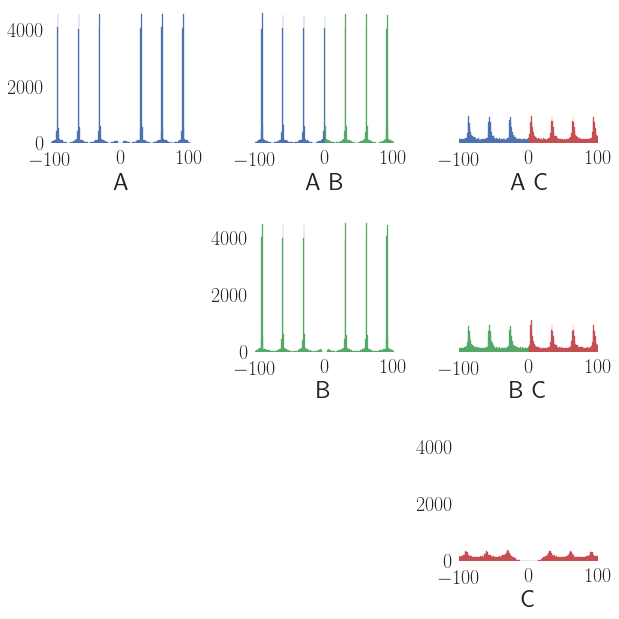

In [137]:
# with sns.axes_style("darkgrid"):
plot_xcorr(spiketrains, colors=colors, time_limit=100, binsize=1, names=names,
           xticksvisible=True, yticksvisible=False, density=False);
sns.despine(bottom=True, left=True)
fig = plt.gcf()
savefig(fig, 'xcorr')

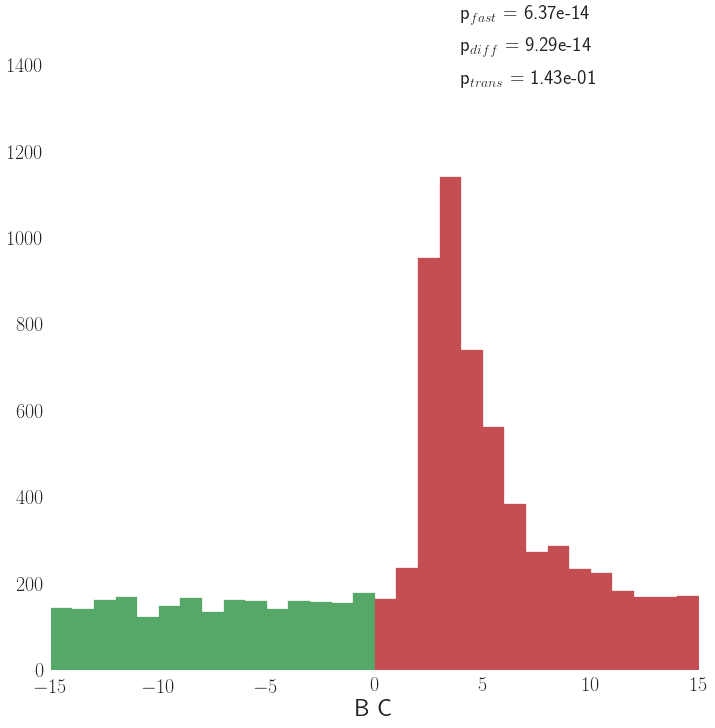

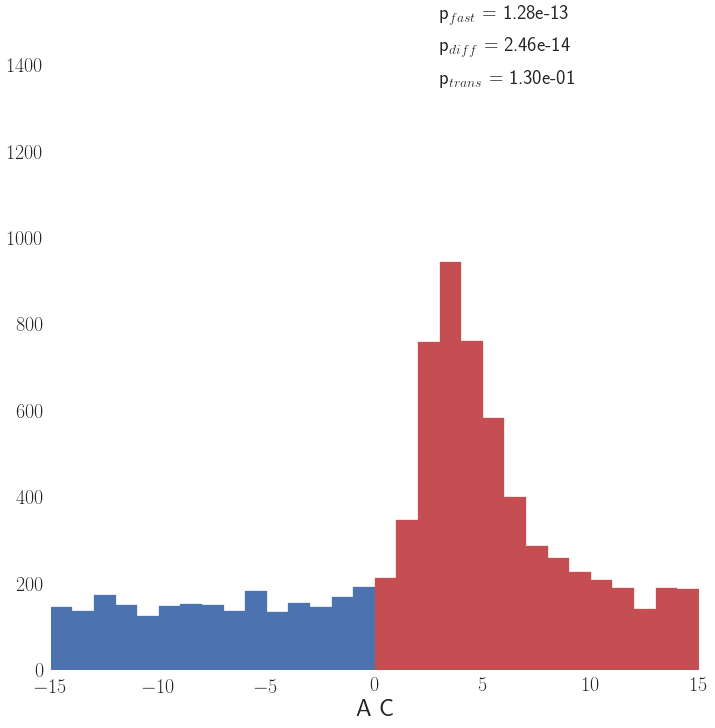

In [147]:
from exana.statistics.tools import ccg_significance
from exana.statistics.plot import plot_xcorr

time_limit = 15
binsize = 1
ylim = [0, 1500]


for idx, sl in enumerate([slice(1,3), slice(0,3,2)]):
    pcausal, pfast, bins, cch, cch_s = ccg_significance(*spiketrains[sl], binsize, time_limit, 
                                            hollow_fraction=.6, width=10)
    
    _, bins = plot_xcorr(spiketrains[sl], colors=colors[sl], time_limit=time_limit, 
                            binsize=binsize, acorr=False, ylim=ylim, density=False,
                            names=names[sl]);
    ax = plt.gca()
    mask = (bins >= 4) & (bins <= 6)
    m = np.max(cch[mask])
    pmin = pcausal[cch == m]
    trans_prob = sum(cch[mask] - cch_s[mask]) / len(spiketrains[sl][0])
#     plt.plot([bins[pcausal==pmin][0], bins[pcausal==pmin][0]], 
#              [0, m], ls='--', c='k')
    plt.annotate('p$_{{fast}}$ = {:.2e}'.format(pfast[cch == m][0]), 
                 [bins[pcausal == pmin][0], ylim[1]])
    plt.annotate('p$_{{diff}}$ = {:.2e}'.format(pcausal[cch == m][0]), 
                 [bins[pcausal == pmin][0], ylim[1] - ylim[1]*.05])
    plt.annotate('p$_{{trans}}$ = {:.2e}'.format(trans_prob), 
                 [bins[pcausal == pmin][0], ylim[1] - ylim[1]*.1])
    ax.set_aspect(time_limit * 2 / ylim[1])
    ax.set_position([0, 0, 1, 1])
    sns.despine(bottom=True, left=True)
    savefig(plt.gcf(), 'xcorr_highres_{}{}'.format(*names[sl]), bbox_inches='tight')

No handles with labels found to put in legend.


rates: A = 36 Hz, B = 36 Hz, C = 25 Hz


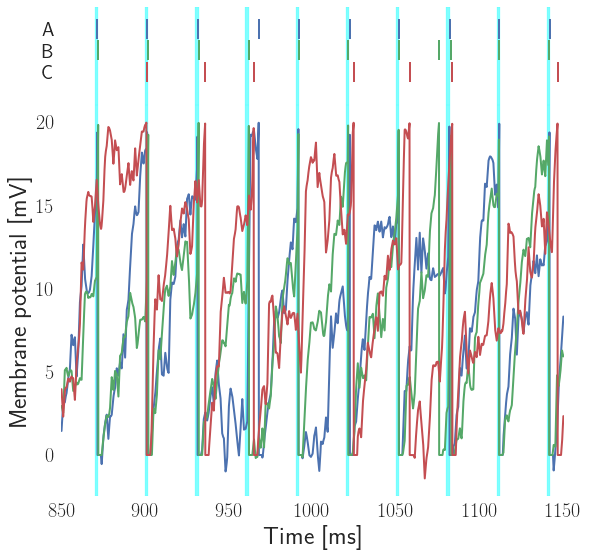

In [130]:
fig = plt.figure()

xlim = [850, 1150]

import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4], hspace=0)
with sns.axes_style("white"):
    ax_v = fig.add_subplot(gs[1])
    ax_s = fig.add_subplot(gs[0], sharex=ax_v)
plt.setp(ax_s.get_xticklabels(), visible=False)

spikes = data['spiketrains']['times']
mask = (spikes > xlim[0]) & (spikes < xlim[1])
senders = data['spiketrains']['senders']
ax_s.scatter(spikes[mask], senders[mask], 
         marker='|', s=400, color=[colors[s-1] for s in data['spiketrains']['senders'][mask]])
ax_s.set_yticks(sorted(set(data['state']['senders'])))
ax_s.set_yticklabels(names)

rates = [len(spikes[senders==sender]) / data['status']['time'] * 1000
         for sender in np.unique(senders)]

for idx in range(3):
    sender = sorted(set(data['state']['senders']))[idx]
    color = colors[idx]
    name = names[idx]
    mask = (data['state']['times'] > xlim[0]) & (data['state']['times'] < xlim[1])
    times = data['state']['times'][mask]
    senders = data['state']['senders'][mask]
    V = data['state']['V_m'][mask]
    assert len(senders) == len(V) == len(times)
    # membrane potential
    ax_v.plot(times[senders==sender], V[senders==sender], 
              label=name, color=color)
for t, d in zip(data['epochs']['times'], data['epochs']['durations']):
    if not t > xlim[0]:
        continue
    elif t > xlim[1]:
        break
    for ax in [ax_v, ax_s]:
        ax.axvspan(t, t + d, color='cyan', zorder=0, alpha=.5)
# ax_v.axhspan(par['V_th'], par['V_th'], color='k')
ax_s.set_ylim([0, 4.5])
plt.xlim(xlim)
plt.legend()
print('rates: A = {:.0f} Hz, B = {:.0f} Hz, C = {:.0f} Hz'.format(*rates))
ax_v.set_ylabel('Membrane potential [mV]')
ax_v.set_xlabel('Time [ms]')
# ax_s.set_ylabel('Neuron')
sns.despine(bottom=True, left=True)
# sns.despine(ax=ax_s, bottom=True)
ax_s.invert_yaxis()
ax_v.set_yticks(range(0,25,5))
savefig(fig, 'traces')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


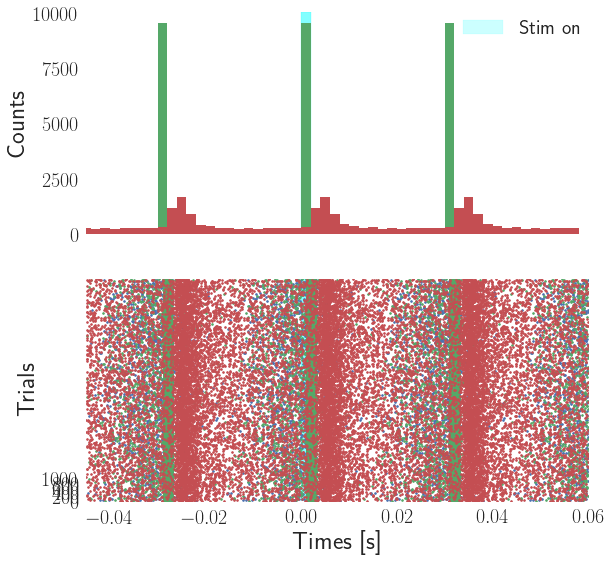

In [131]:
from exana.stimulus import plot_psth
import neo

spiketrains_neo = [neo.SpikeTrain(times=np.array(attr['times'])*pq.ms, 
                              t_start=0*pq.ms, t_stop=t_stop*pq.ms, name=names[sndr-1])
               for sndr, attr in df.groupby('senders')]
epoch = neo.Epoch(times=data_l['epochs']['times'] * pq.ms, 
                  durations=data_l['epochs']['durations'] * pq.ms)

fig, axs = plt.subplots(2,1, sharex=True)
for n, sptr in enumerate(spiketrains_neo):
    plot_psth(spike_train=sptr, epoch=epoch, xlim=[-.045, .06] * pq.s, axs=axs, hist_binsize=2*pq.ms,
              color=colors[n], stim_color='cyan', hist_alpha=1., hist_edgecolor=None, 
              hist_ylabel='Counts');
sns.despine(bottom=True, left=True)
fig = plt.gcf()
ax_t = fig.axes[-1]
ax_t.set_yticks(range(0,1200,200))
savefig(fig, 'raster')


In [142]:
iva = IV(spiketrains[0], 
         spiketrains[2],
         data['epochs']['times'],
         winsize=4, latency=4)

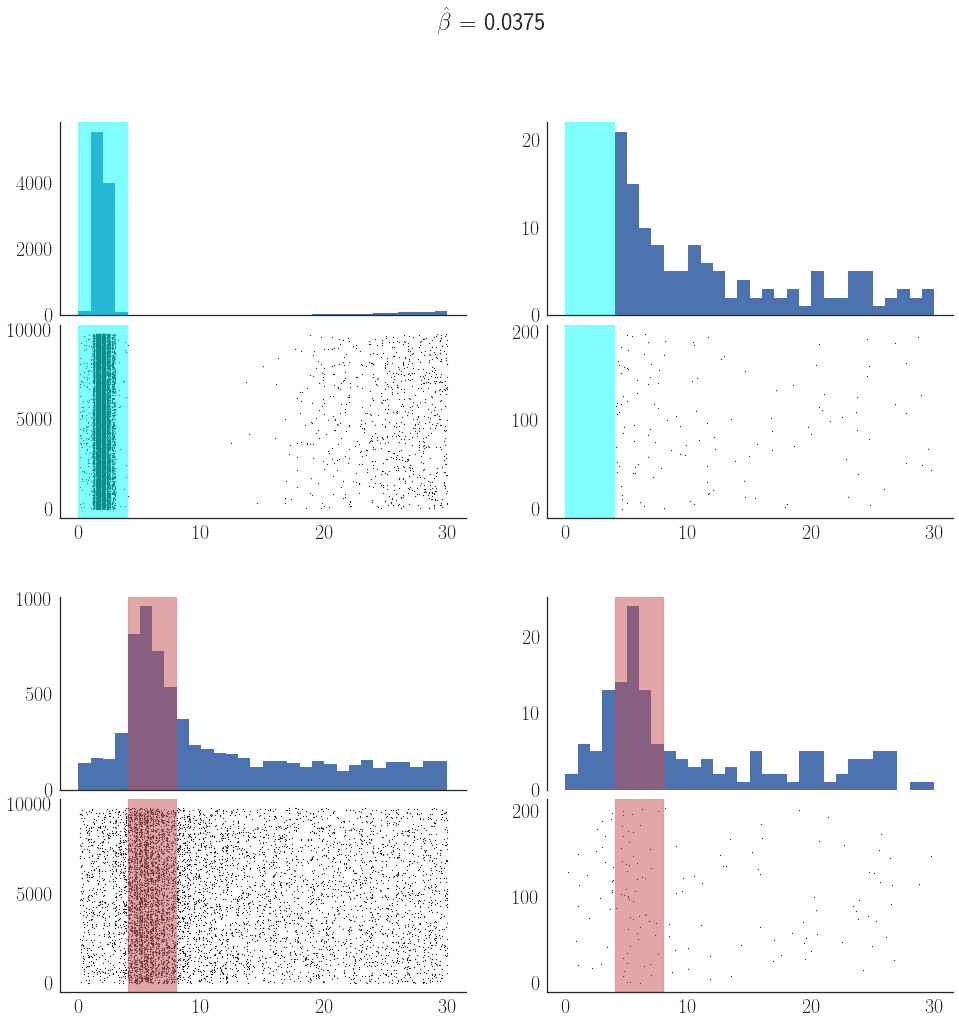

In [143]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(16,16))
gs = GridSpec(2, 2)
for i, idxs in enumerate([iva.Stim, iva.StimRef]):
    iva.plot('source', idxs, gs=gs[0, i])
    iva.plot('target', idxs, gs=gs[1, i])
plt.suptitle('$\\hat\\beta$ = {:.4f}'.format(iva.wald));

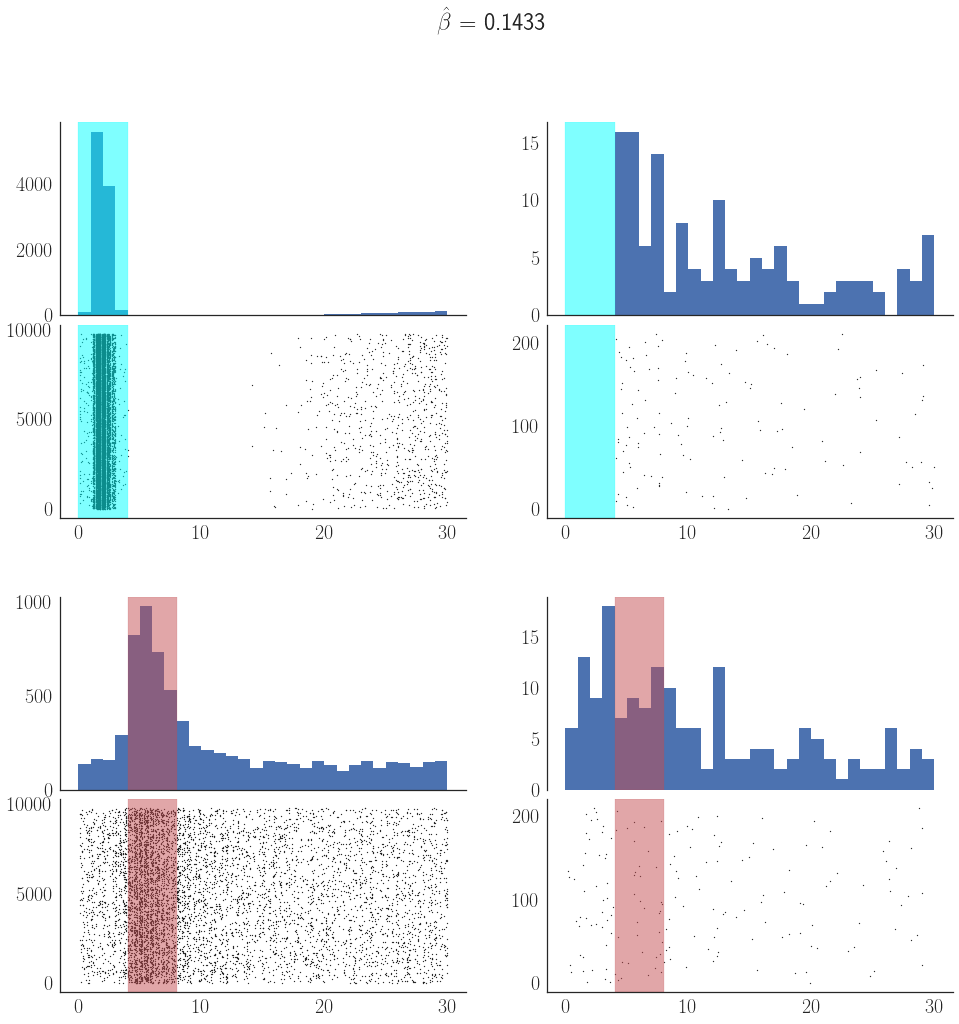

In [145]:
ivb = IV(spiketrains[1], 
         spiketrains[2],
         data['epochs']['times'],
         winsize=4, latency=4)

fig = plt.figure(figsize=(16,16))
gs = GridSpec(2, 2)
for i, idxs in enumerate([ivb.Stim, ivb.StimRef]):
    ivb.plot('source', idxs, gs=gs[0, i])
    ivb.plot('target', idxs, gs=gs[1, i])
plt.suptitle('$\\hat\\beta$ = {:.4f}'.format(ivb.wald));